#### **Problem №2: Bicycle Dynamics**

Consider the following system:

<p align="center">
<img src="https://simeon-ned.github.io/robotic_systems/assets/images/systems/bicycle.svg" alt="drawing" width="60%" style="margin:auto"/>
</p>


Do the following:

* **[10 points]** Propose the coordinates that will represent configuration of the system, derive the unconstrained dynamics, introduce the appropriate constraints (holonomic and nonholonomic) and convert them in to generalized form: $\mathbf{A}(\mathbf{q},\dot{\mathbf{q}},t) \ddot{\mathbf{q}} = \mathbf{b}(\mathbf{q}, \dot{\mathbf{q}}, t)$.

* **[15 points]** Set the external forces $\mathbf{Q}$ to represent the actuation of the system as it shown on the Fig. (b), simulate the behaviour of the system using Runge-Kutta, starting from feasible configuration similar to on the above figure while letting $u_1 = 4$ and $u_2 = 0$, plot the trajectories, and time evoluation of constraints. Animate the resulting motion. Introduce and tune the bamguart stabilization

* **[5 points]** Change the actuation forces to represent the given on figure, with $u_1 = 4$ and $u_2 =  5(1.2\sin(t) - \alpha) - \dot{\alpha}$, repeat the above steps. Discuss the results.
---


In [22]:
import sympy as sp

t = sp.symbols('t', real=True)
m1, m2, I1, I2, l = sp.symbols('m1 m2 I1 I2 l')
q = sp.symbols(r'x1 y1 theta_1 x2 y2 theta_2', cls=sp.Function)
q = sp.Matrix([q[i](t) for i in range(len(q))])
dq = sp.Matrix([sp.diff(q[i], t) for i in range(len(q))])
ddq = sp.Matrix([sp.diff(dq[i], t) for i in range(len(q))])

q, dq, ddq

(Matrix([
 [     x1(t)],
 [     y1(t)],
 [theta_1(t)],
 [     x2(t)],
 [     y2(t)],
 [theta_2(t)]]),
 Matrix([
 [     Derivative(x1(t), t)],
 [     Derivative(y1(t), t)],
 [Derivative(theta_1(t), t)],
 [     Derivative(x2(t), t)],
 [     Derivative(y2(t), t)],
 [Derivative(theta_2(t), t)]]),
 Matrix([
 [     Derivative(x1(t), (t, 2))],
 [     Derivative(y1(t), (t, 2))],
 [Derivative(theta_1(t), (t, 2))],
 [     Derivative(x2(t), (t, 2))],
 [     Derivative(y2(t), (t, 2))],
 [Derivative(theta_2(t), (t, 2))]]))

In [23]:
# define holonomic constraints
# distance between is l

x1, y1, t1, x2, y2, t2 = q
r1 = sp.Matrix([
    [x1],
    [y1],
])
r2 = sp.Matrix([
    [x2],
    [y2],
])

dr1 = sp.Matrix([
    [dq[0]],
    [dq[1]],
])

dr2 = sp.Matrix([
    [dq[3]],
    [dq[4]],
])

phi = sp.Matrix([
    [((r1 - r2).T * (r1 - r2))[0] - l**2],
    [(sp.Matrix([sp.sin(t1), -sp.cos(t1)]).T * (r2 - r1))[0]],
])

# define nonholonomic constraints
# non sliding motion of wheels along the plane
psi = sp.Matrix([
    [dr1.T @ sp.Matrix([sp.sin(t1), -sp.cos(t1)])],
    [dr2.T @ sp.Matrix([sp.sin(t2), -sp.cos(t2)])],
])


### Formulation of constraints in form $\mathbf{A}(\mathbf{q},\dot{\mathbf{q}},t) \ddot{\mathbf{q}} = \mathbf{b}(\mathbf{q}, \dot{\mathbf{q}}, t)$

In [25]:
A = sp.zeros(len(phi) + len(psi), len(ddq))
b = sp.zeros(len(phi) + len(psi), 1)

A[:len(phi), :] = phi.jacobian(q)
A[len(phi):, :] = psi.jacobian(dq)

stabs = sp.symbols('alpha0:3')

b[:len(phi), :] = -phi.jacobian(q).diff(t) @ dq - stabs[0] * phi - stabs[1] * phi.jacobian(q) @ dq
b[len(phi):, :] = -psi.jacobian(q) @ dq - stabs[2] * psi

A

Matrix([
[2*x1(t) - 2*x2(t), 2*y1(t) - 2*y2(t),                                                                   0, -2*x1(t) + 2*x2(t), -2*y1(t) + 2*y2(t), 0],
[ -sin(theta_1(t)),   cos(theta_1(t)), (-x1(t) + x2(t))*cos(theta_1(t)) + (-y1(t) + y2(t))*sin(theta_1(t)),    sin(theta_1(t)),   -cos(theta_1(t)), 0],
[  sin(theta_1(t)),  -cos(theta_1(t)),                                                                   0,                  0,                  0, 0],
[                0,                 0,                                                                   0,    sin(theta_2(t)),   -cos(theta_2(t)), 0]])

In [26]:
b

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                 -alpha0*(-l**2 + (x1(t) - x2(t))**2 + (y1(t) - y2(t))**2) - alpha1*(-2*x1(t) + 2*x2(t))*Derivative(x2(t), t) - alpha1*(2*x1(t) - 2*x2(t))*Derivative(x1(t), t) - alpha1*(-2*y1(t) + 2*y2(t))*Derivative(y2(t), t) - alpha1*(2*y1(t) - 2*y2(t))*Derivative(y1(t), t) + (-2*Derivative(x1(t), t) + 2*Derivative(x2(t), t))*Derivative(x1(t), t) + (2*Derivative(x1(t), t) - 2*Derivative(x2(t), t))*Derivative(x2(t), t) + (-2*Derivative(y1(t), t) + 2*Derivative(y2(t), t))*Derivative(y1(t), t) + (2*Derivative(y1(t), t) - 2*Derivative(y2(t), t))*Derivative(y2(t), t)],
[-alpha0*((-x1(t) + x2(t))*sin(theta_1(t)) - (-y1(t) + y2(t))*cos(theta_1(t))) - 

In [27]:
# formulate free dynamics
M = sp.diag(m1, m1, I1, m2, m2, I2)

# define external forces
# u1 is force applied to rear (1st) wheel
# u2 is force applied to lead (2nd) wheel
# u3 is torque for rotation of lead (2nd) wheel
u = sp.Matrix([sp.symbols('u1 u2 u3')]).T

B = sp.Matrix([
    [sp.cos(q[2]), 0, 0],
    [sp.sin(q[2]), 0, 0],
    [0, 0, 0],
    [0, sp.cos(q[5]), 0],
    [0, sp.sin(q[5]), 0],
    [0, 0, 1],
])

Q = B @ u

Q

Matrix([
[u1*cos(theta_1(t))],
[u1*sin(theta_1(t))],
[                 0],
[u2*cos(theta_2(t))],
[u2*sin(theta_2(t))],
[                u3]])

In [28]:
M

Matrix([
[m1,  0,  0,  0,  0,  0],
[ 0, m1,  0,  0,  0,  0],
[ 0,  0, I1,  0,  0,  0],
[ 0,  0,  0, m2,  0,  0],
[ 0,  0,  0,  0, m2,  0],
[ 0,  0,  0,  0,  0, I2]])

### $u_1 = 4$ and $u_2 = 0$, plot the trajectories, and time evoluation of constraints

In [29]:
parameters = dict(
    m1=1.0,  # [kg] - mass distributed around front wheel
    m2=2.0,  # [kg] - mass distributed around rear wheel
    I2=0.1,  # [kg*m^2] - inertia of front wheel
    I1=1.0,  # [kg*m^2] - combined inertia of frame and rear wheel
    l=0.5,  # [m] - length between wheels
)

# create lambdified functions for numerical evaluation
numericals = dict(
    M=sp.lambdify((q, ), M.subs(parameters)),
    Q=sp.lambdify((q, u), Q.subs(parameters)),
    A=sp.lambdify((q, ), A.subs(parameters)),
    b=sp.lambdify((q, dq, stabs), b.subs(parameters)),
    phi=sp.lambdify((q, ), phi.subs(parameters)),
    psi=sp.lambdify((q, dq), psi.subs(parameters)),
)

In [30]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import fractional_matrix_power as mpow
from numpy.linalg import pinv


def dynamics(t, x, u):
    q, dq = x[:len(x) // 2], x[len(x) // 2:]

    Mn = numericals['M'](q)
    Qn = numericals['Q'](q, u)
    An = numericals['A'](q)
    bn = numericals['b'](q, dq, [0, 0, 0])


    # solve for ddq
    ddq = np.linalg.inv(Mn) @ Qn - mpow(Mn, -1/2) @ pinv(An @
                                                         mpow(Mn, -1/2)) @ (An @ mpow(Mn, -1) @ Qn - bn)

    return np.concatenate([dq, ddq.T[0]])


# initial conditions
x0 = np.array([0, 0, 0, parameters['l'], 0, 0, 0, 0, 0, 0, 0, 0])
u = np.array([4, 0, 0])

# solve
sol = solve_ivp(dynamics, (0, 3), x0, args=(u, ), max_step=0.01)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.293e-04 ...  2.996e+00  3.000e+00]
        y: [[ 0.000e+00  1.868e-07 ...  5.983e+00  6.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1814
     njev: 0
      nlu: 0

In [31]:
def dump_task2(ts, xs, name, norm = 100):

    vertices = []
    segments = []

    for i in range(len(ts)):
        vertex0 = [xs[i][0], xs[i][1], 0]
        vertex1 = [xs[i][3], xs[i][4], 0]
        vertex2 = [xs[i][3] + 0.2 * np.cos(xs[i][5]), xs[i][4] + 0.2 * np.sin(xs[i][5]), 0]
        vertex3 = [xs[i][0] + 0.2 * np.cos(xs[i][2]), xs[i][1] + 0.2 * np.sin(xs[i][2]), 0]

        vertices.append([vertex0, vertex1, vertex2, vertex3])
        segments.append([[vertex0, vertex1]])

    data = {
        'name': name,
        'vertices': vertices,
        'segments': segments,
        'ts': ts.tolist()
    }
    import json
    with open(f'{name}.json', 'w') as f:
        json.dump(data, f)
dump_task2(sol.t, sol.y.T, 'task2_1')

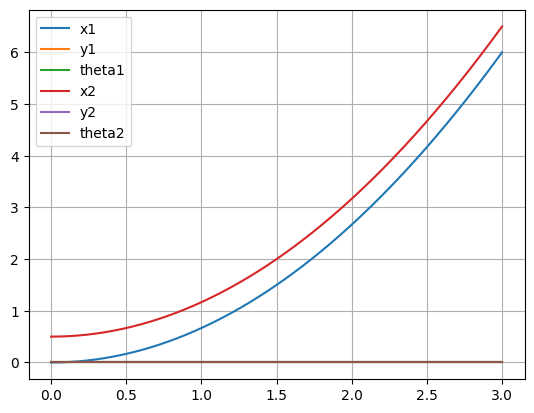

In [32]:
# plot
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0], label='x1')
plt.plot(sol.t, sol.y[1], label='y1')
plt.plot(sol.t, sol.y[2], label='theta1')
plt.plot(sol.t, sol.y[3], label='x2')
plt.plot(sol.t, sol.y[4], label='y2')
plt.plot(sol.t, sol.y[5], label='theta2')
plt.legend()
plt.grid()
plt.show()

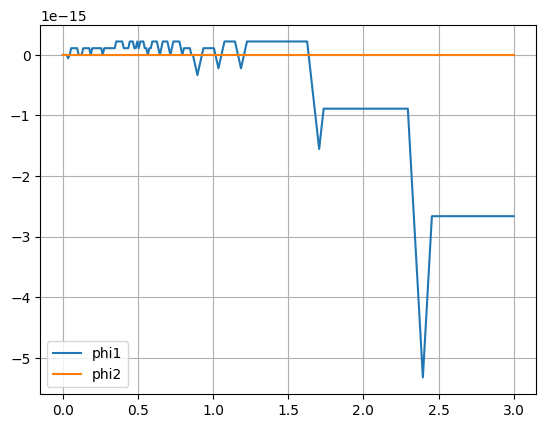

In [33]:
# plot constraints
plt.plot(sol.t, numericals['phi'](sol.y[:6]).T[:, 0, :], label=['phi1', 'phi2',])
plt.grid()
plt.legend()
plt.show()


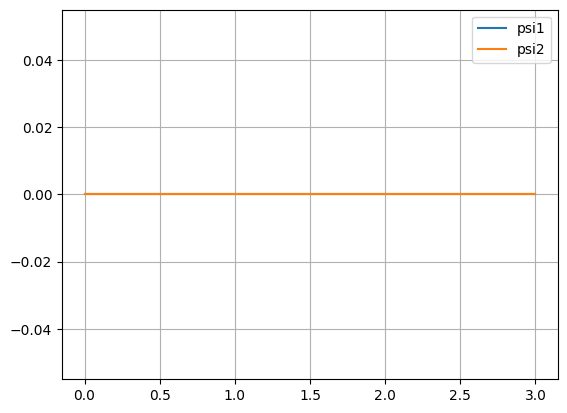

In [34]:
# plot constraints
plt.plot(sol.t, numericals['psi'](sol.y[:6], sol.y[6:]).T[:, 0, :], label=['psi1', 'psi2',])
plt.grid()
plt.legend()
plt.show()


In [35]:

def save(fname: str, sol):
    import json
    with open(f'data/{fname}.json', 'w') as f:
        # [time, x1, y1, theta1, x2, y2, theta2]
        result = np.array([sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5]]).T
        json.dump(result.tolist(), f)

save('task2_1', sol)


## same with stabilize

In [36]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import fractional_matrix_power as mpow
from numpy.linalg import pinv


def dynamics(t, x, u):
    q, dq = x[:len(x) // 2], x[len(x) // 2:]

    Mn = numericals['M'](q)
    Qn = numericals['Q'](q, u)
    An = numericals['A'](q)
    bn = numericals['b'](q, dq, [100, 100, 100])


    # solve for ddq
    ddq = np.linalg.inv(Mn) @ Qn - mpow(Mn, -1/2) @ pinv(An @
                                                         mpow(Mn, -1/2)) @ (An @ mpow(Mn, -1) @ Qn - bn)

    return np.concatenate([dq, ddq.T[0]])


# initial conditions
x0 = np.array([0, 0, 0, parameters['l'], 0, 0, 0, 0, 0, 0, 0, 0])
u = np.array([4, 0, 0])

# solve
sol = solve_ivp(dynamics, (0, 3), x0, args=(u, ), max_step=0.01)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.293e-04 ...  2.996e+00  3.000e+00]
        y: [[ 0.000e+00  1.868e-07 ...  5.983e+00  6.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1814
     njev: 0
      nlu: 0

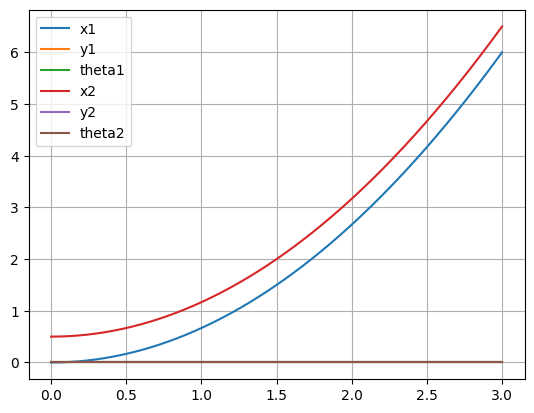

In [37]:
# plot
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0], label='x1')
plt.plot(sol.t, sol.y[1], label='y1')
plt.plot(sol.t, sol.y[2], label='theta1')
plt.plot(sol.t, sol.y[3], label='x2')
plt.plot(sol.t, sol.y[4], label='y2')
plt.plot(sol.t, sol.y[5], label='theta2')
plt.legend()
plt.grid()
plt.show()

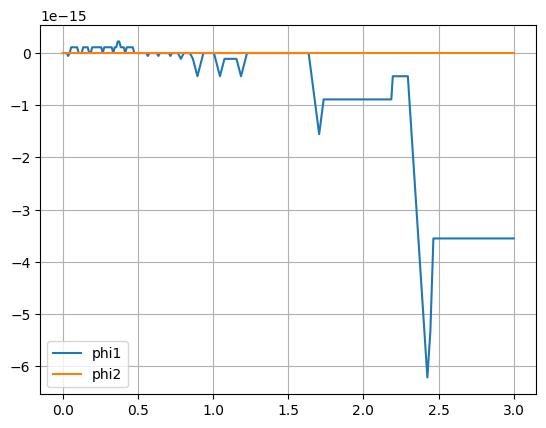

In [38]:
# plot constraints
plt.plot(sol.t, numericals['phi'](sol.y[:6]).T[:, 0, :], label=['phi1', 'phi2',])
plt.grid()
plt.legend()
plt.show()


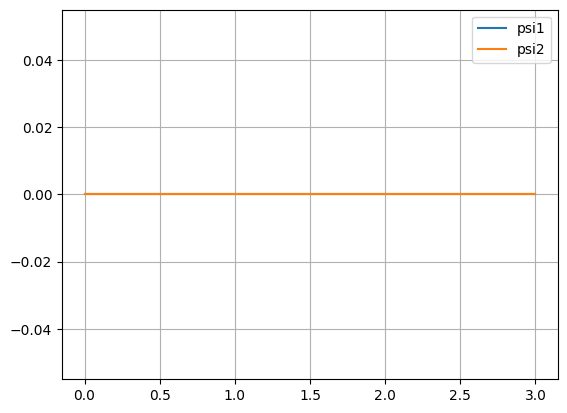

In [39]:
# plot constraints
plt.plot(sol.t, numericals['psi'](sol.y[:6], sol.y[6:]).T[:, 0, :], label=['psi1', 'psi2',])
plt.grid()
plt.legend()
plt.show()


In [40]:

def save(fname: str, sol):
    import json
    with open(f'data/{fname}.json', 'w') as f:
        # [time, x1, y1, theta1, x2, y2, theta2]
        result = np.array([sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5]]).T
        json.dump(result.tolist(), f)

save('task2_1_stab', sol)


### Change actuators to $u_1 = 4$ and $u_2 =  5(1.2\sin(t) - \alpha) - \dot{\alpha}$

In [41]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import fractional_matrix_power as mpow
from numpy.linalg import pinv


def dynamics(t, x):
    q, dq = x[:len(x) // 2], x[len(x) // 2:]

    u = np.array([
        0,
        4,
        5 * (1.2 * np.sin(t) - q[5]) - dq[5],
    ])

    Mn = numericals['M'](q)
    Qn = numericals['Q'](q, u)
    An = numericals['A'](q)
    bn = numericals['b'](q, dq, [0, 0, 0])

    # solve for ddq
    ddq = np.linalg.inv(Mn) @ Qn - mpow(Mn, -1/2) @ pinv(An @
                                                         mpow(Mn, -1/2)) @ (An @ mpow(Mn, -1) @ Qn - bn)

    return np.concatenate([dq, ddq.T[0]])


# initial conditions
x0 = np.array([0, 0, 0, parameters['l'], 0, 0, 0, 0, 0, 0, 0, 0])

sol = solve_ivp(dynamics, (0, 10), x0, max_step=0.01)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.293e-04 ...  9.996e+00  1.000e+01]
        y: [[ 0.000e+00  1.868e-07 ...  4.535e+01  4.540e+01]
            [ 0.000e+00  1.272e-23 ...  1.225e+01  1.223e+01]
            ...
            [ 0.000e+00  1.045e-12 ... -5.542e+00 -5.600e+00]
            [ 0.000e+00  8.389e-06 ... -1.119e+00 -1.117e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6014
     njev: 0
      nlu: 0

In [42]:
dump_task2(sol.t, sol.y.T, 'task2_2')

In [43]:
save('task2_2', sol)

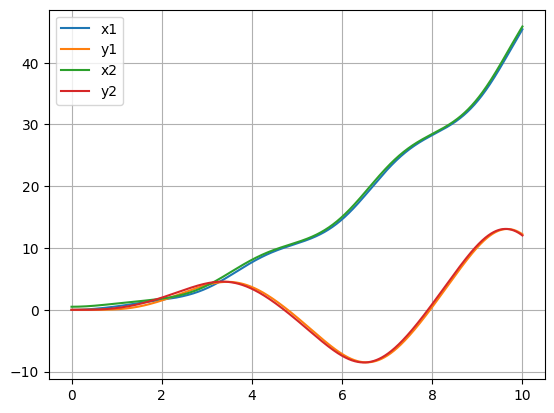

In [44]:
# plot
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0], label='x1')
plt.plot(sol.t, sol.y[1], label='y1')
# plt.plot(sol.t, sol.y[2], label='theta1')
plt.plot(sol.t, sol.y[3], label='x2')
plt.plot(sol.t, sol.y[4], label='y2')
# plt.plot(sol.t, sol.y[5], label='theta2')
plt.legend()
plt.grid()
plt.show()

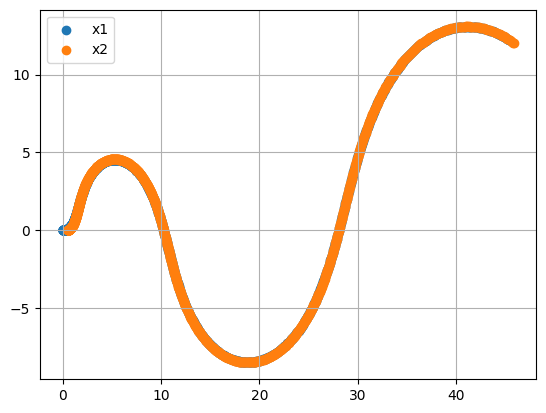

In [45]:
# scatter plot of positions
plt.scatter(sol.y[0], sol.y[1], label='x1')
plt.scatter(sol.y[3], sol.y[4], label='x2')
plt.legend()
plt.grid()

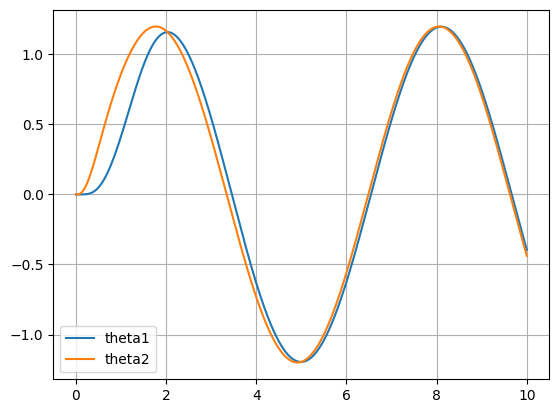

In [46]:
# plot
import matplotlib.pyplot as plt

# plt.plot(sol.t, sol.y[0], label='x1')
# plt.plot(sol.t, sol.y[1], label='y1')
plt.plot(sol.t, sol.y[2], label='theta1')
# plt.plot(sol.t, sol.y[3], label='x2')
# plt.plot(sol.t, sol.y[4], label='y2')
plt.plot(sol.t, sol.y[5], label='theta2')
plt.legend()
plt.grid()
plt.show()

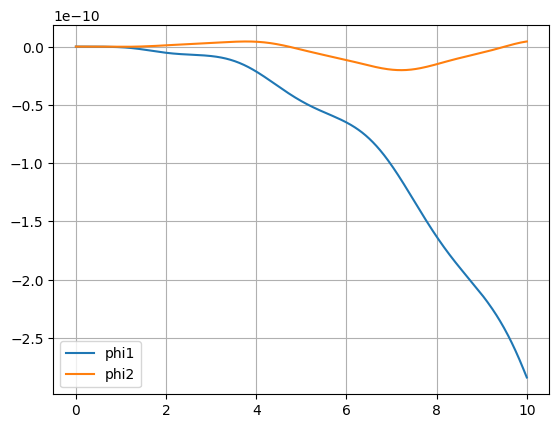

In [47]:
# plot constraints
plt.plot(sol.t, numericals['phi'](sol.y[:6]).T[:, 0, :], label=['phi1', 'phi2',])
plt.grid()
plt.legend()
plt.show()


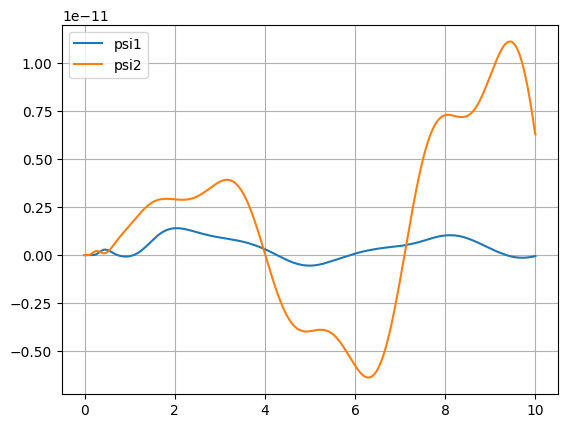

In [48]:
# plot constraints
plt.plot(sol.t, numericals['psi'](sol.y[:6], sol.y[6:]).T[:, 0, :], label=['psi1', 'psi2',])
plt.grid()
plt.legend()
plt.show()


## same with stabilize

In [49]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import fractional_matrix_power as mpow
from numpy.linalg import pinv


def dynamics(t, x):
    q, dq = x[:len(x) // 2], x[len(x) // 2:]

    u = np.array([
        0,
        4,
        5 * (1.2 * np.sin(t) - q[5]) - dq[5],
    ])

    Mn = numericals['M'](q)
    Qn = numericals['Q'](q, u)
    An = numericals['A'](q)
    bn = numericals['b'](q, dq, [100, 100, 100])

    # solve for ddq
    ddq = np.linalg.inv(Mn) @ Qn - mpow(Mn, -1/2) @ pinv(An @
                                                         mpow(Mn, -1/2)) @ (An @ mpow(Mn, -1) @ Qn - bn)

    return np.concatenate([dq, ddq.T[0]])


# initial conditions
x0 = np.array([0, 0, 0, parameters['l'], 0, 0, 0, 0, 0, 0, 0, 0])

sol = solve_ivp(dynamics, (0, 10), x0, max_step=0.01)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.293e-04 ...  9.996e+00  1.000e+01]
        y: [[ 0.000e+00  1.868e-07 ...  4.535e+01  4.540e+01]
            [ 0.000e+00  1.282e-23 ...  1.225e+01  1.223e+01]
            ...
            [ 0.000e+00  1.045e-12 ... -5.542e+00 -5.600e+00]
            [ 0.000e+00  8.389e-06 ... -1.119e+00 -1.117e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6014
     njev: 0
      nlu: 0

In [50]:
save('task2_2', sol)

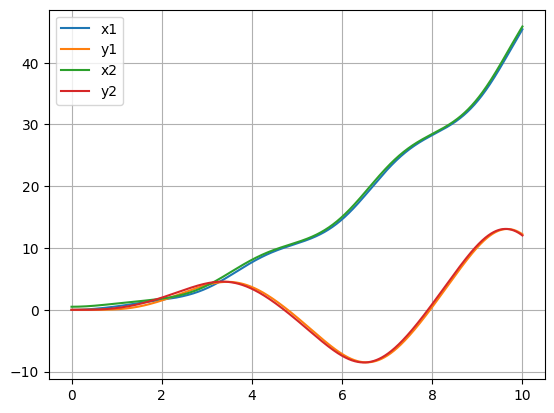

In [51]:
# plot
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0], label='x1')
plt.plot(sol.t, sol.y[1], label='y1')
# plt.plot(sol.t, sol.y[2], label='theta1')
plt.plot(sol.t, sol.y[3], label='x2')
plt.plot(sol.t, sol.y[4], label='y2')
# plt.plot(sol.t, sol.y[5], label='theta2')
plt.legend()
plt.grid()
plt.show()

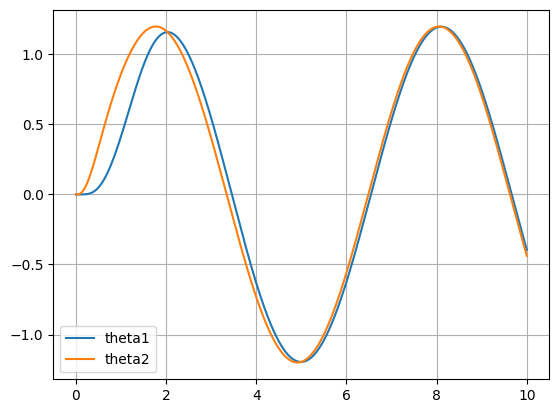

In [52]:
# plot
import matplotlib.pyplot as plt

# plt.plot(sol.t, sol.y[0], label='x1')
# plt.plot(sol.t, sol.y[1], label='y1')
plt.plot(sol.t, sol.y[2], label='theta1')
# plt.plot(sol.t, sol.y[3], label='x2')
# plt.plot(sol.t, sol.y[4], label='y2')
plt.plot(sol.t, sol.y[5], label='theta2')
plt.legend()
plt.grid()
plt.show()

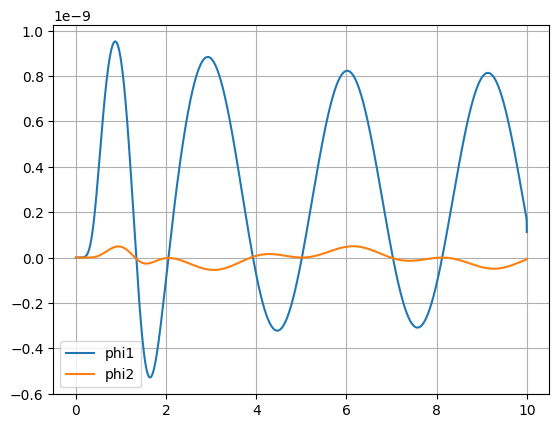

In [54]:
# plot constraints
plt.plot(sol.t, numericals['phi'](sol.y[:6]).T[:, 0, :], label=['phi1', 'phi2',])
plt.grid()
plt.legend()
plt.show()


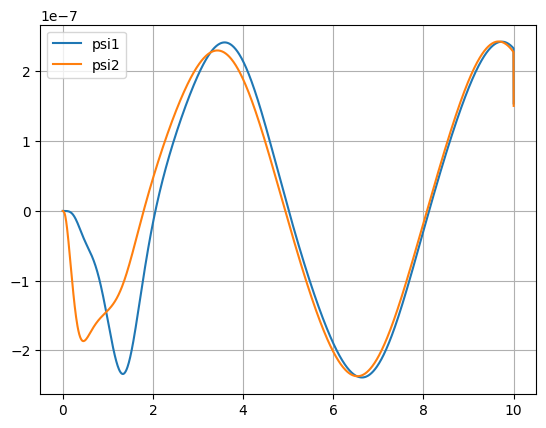

In [53]:
# plot constraints
plt.plot(sol.t, numericals['psi'](sol.y[:6], sol.y[6:]).T[:, 0, :], label=['psi1', 'psi2',])
plt.grid()
plt.legend()
plt.show()
